In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

paths = {}

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        paths[filename] = os.path.join(dirname, filename)

/kaggle/input/movie-recommendation-system/movies.csv
/kaggle/input/movie-recommendation-system/ratings.csv


In [82]:
from sklearn.preprocessing import MultiLabelBinarizer # one-hot encoding 
from sklearn.neighbors import NearestNeighbors # KNN

In [83]:
ratings = pd.read_csv(paths["ratings.csv"])
movies = pd.read_csv(paths["movies.csv"])

print("Datasets loaded")

Datasets loaded


In [84]:
print(movies.shape)
movies.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [85]:
print(ratings.shape)
ratings.head()

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [86]:
unique_users = len(ratings["userId"].unique())
movies_count = len(movies["movieId"].unique())

print(unique_users, movies_count)

162541 62423


<Axes: xlabel='rating'>

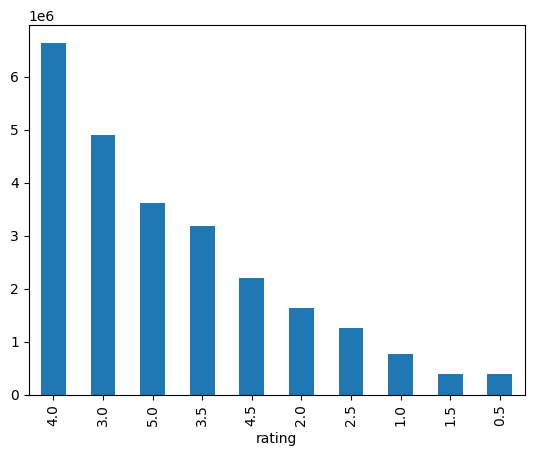

In [87]:
ratings['rating'].value_counts().plot(kind='bar')

In [88]:
# combine data
merged_data = pd.merge(ratings, movies, on='movieId')

print(merged_data.shape)
merged_data.head()

(25000095, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


In [89]:
data = movies

# one-hot encoding
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(data['genres'].str.split('|'))
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

data = pd.concat([data, genre_df], axis=1)
data.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Model 1: KNN Based Genre Similarity
This model employs a K-Nearest Neighbors (KNN) algorithm to recommend movies based solely on their genres. By creating a feature matrix that includes only the movie titles and their associated genres, it simplifies the data to focus exclusively on genre similarity. When a user inputs a movie, the model identifies the K nearest movies in the feature space based on their genre composition. This approach allows for quick recommendations of films that are closely aligned in genre.

In [90]:
features = data.drop(columns=[
#     'userId', 'rating', 'timestamp', 
    'genres', 'title', 'movieId'])

features.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
knn_model_genres = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn_model_genres.fit(features)

NearestNeighbors()

In [139]:
def recommend_similar_movies_model1(movie_title, *, n=5, model=knn_model_genres, data=movies, features=features):
    movie_idx = data[data['title'] == movie_title].index[0]
    distances, indices = model.kneighbors(features.iloc[movie_idx, :].values.reshape(1, -1), n_neighbors=n)
    recommended_movies = data.iloc[indices.flatten()]
    return recommended_movies

recommend_similar_movies_model1("Toy Story (1995)")

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,movieId,title,genres
60800,204188,UglyDolls (2019),Adventure|Animation|Children|Comedy|Fantasy
52833,186177,Trolls Holiday (2017),Adventure|Animation|Children|Comedy|Fantasy
58039,197743,Here Comes the Grump (2018),Adventure|Animation|Children|Comedy|Fantasy
55898,192981,Penguin Highway (2018),Adventure|Animation|Children|Comedy|Fantasy
2203,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy


# Model 2: User-Item Matrix with Cosine Similarity
This model utilizes a user-item matrix combined with cosine similarity to enhance movie recommendations by incorporating user ratings. The model captures the relationships between users and their rated movies and identifies films that are similar in terms of user preferences. When a user inputs a movie, the model retrieves other movies that are most similar according to the cosine similarity measure, resulting in personalized recommendations that reflect the tastes and preferences of users who liked similar movies. This approach considers both the content of the movies and user interactions but may be more suited when user data is collected by the website.

In [131]:
# training on 5% of all data for performance reasons
filtered_data = merged_data.head(merged_data.shape[0] // 20)

user_item_matrix = filtered_data.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)
print(user_item_matrix.shape)

(22938, 8455)


In [132]:
# normalize ratings
mean_user_rating = np.mean(np.array(user_item_matrix), axis=1).reshape(-1, 1)

normalized_matrix = user_item_matrix - mean_user_rating

In [133]:
knn_model_matrix = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='auto')
knn_model_matrix.fit(normalized_matrix)

NearestNeighbors(metric='cosine')

In [140]:
def recommend_similar_movies_model2(movie_title, n=5, model=knn_model_matrix, data=filtered_data, features=normalized_matrix):
    movie_idx = data[data['title'] == movie_title].index[0]
    distances, indices = model.kneighbors(features.iloc[movie_idx].values.reshape(1, -1), n_neighbors=n)
    recommended_movies = data.iloc[indices.flatten()]
    return recommended_movies

recommend_similar_movies_model2("Toy Story (1995)")

,userId,movieId,rating,timestamp,title,genres
70,2,1,3.5,1141415820,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
538,3,8984,4.0,1439473057,Ocean's Twelve (2004),Action|Comedy|Crime|Thriller
541,3,27660,4.0,1566090435,"Animatrix, The (2003)",Action|Animation|Drama|Sci-Fi
130,2,1610,5.0,1141416601,"Hunt for Red October, The (1990)",Action|Adventure|Thriller
669,3,62999,3.5,1566090989,Madagascar: Escape 2 Africa (2008),Action|Adventure|Animation|Children|Comedy|IMAX
